In [1]:
from pprint import pformat

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [12]:
df = pd.read_csv("aggregated_results/2023-03-31.csv")
df

,task_name,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc,network,label,method,nodefeat,runid
0,GO:0016477,4.762529,1.834189,1.253926,0.984630,0.784157,0.657400,humannet,gobp,gin,randprojs32,1
1,GO:0150104,6.049809,4.801452,5.250726,0.999243,0.948518,0.969119,humannet,gobp,gin,randprojs32,1
2,GO:0043065,3.720991,3.213864,0.629417,0.961403,0.767075,0.621604,humannet,gobp,gin,randprojs32,1
3,GO:0071456,5.978249,1.678232,2.034271,0.997382,0.695144,0.794595,humannet,gobp,gin,randprojs32,1
4,GO:0010629,4.034316,1.369066,1.511406,0.958316,0.680769,0.758446,humannet,gobp,gin,randprojs32,1
...,...,...,...,...,...,...,...,...,...,...,...,...
95387,GO:0007160,4.730158,4.713477,3.641337,0.940623,0.825211,0.699166,humannet,gobp,gat,onehotlogdeg128,1
95388,GO:0001227,3.803783,3.805382,2.846626,0.946873,0.893691,0.894862,humannet,gobp,gat,onehotlogdeg128,1
95389,GO:0003714,2.741778,2.678627,1.926575,0.898088,0.839625,0.820319,humannet,gobp,gat,onehotlogdeg128,1
95390,GO:0007601,5.212449,3.561347,3.734348,0.887785,0.762252,0.799499,humannet,gobp,gat,onehotlogdeg128,1


In [13]:
method_name_mapping = {
    "gat": "GAT",
    "gcn": "GCN",
    "gin": "GIN",
    "graphsage": "GraphSAGE",
}

network_name_mapping = {
    "humannet": "HumanNet",
    "biogrid": "BioGRID",
}

label_name_mapping = {
    "diseases": "DISEASES",
    "disgenet": "DisGeNET",
    "gobp": "GOBP",
}

df["network"] = df["network"].apply(network_name_mapping.get)
df["method"] = df["method"].apply(method_name_mapping.get)
df["label"] = df["label"].apply(label_name_mapping.get)

In [4]:
reduced_df = (
    df
    .groupby(["task_name", "network", "label", "method", "nodefeat"], as_index=False)
    .mean()
    .drop(columns="runid")
)
reduced_df

,task_name,network,label,method,nodefeat,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc
0,GO:0000165,BioGRID,GOBP,GAT,const1,1.197963,0.470046,2.267870,0.450309,0.577552,0.544404
1,GO:0000165,BioGRID,GOBP,GAT,lappe32,0.702156,0.326062,0.161211,0.575829,0.552484,0.476298
2,GO:0000165,BioGRID,GOBP,GAT,logdeg1,2.554406,0.586741,-0.242888,0.734181,0.537669,0.353435
3,GO:0000165,BioGRID,GOBP,GAT,node2vec128,3.130887,1.849210,0.865555,0.905237,0.798735,0.496250
4,GO:0000165,BioGRID,GOBP,GAT,node2vec32,4.523092,1.873954,2.087387,0.925298,0.749322,0.435344
...,...,...,...,...,...,...,...,...,...,...,...
95387,MONDO:0700092,HumanNet,DisGeNET,GraphSAGE,randprojs32,3.791425,1.881867,2.815520,0.951036,0.687706,0.678706
95388,MONDO:0700092,HumanNet,DisGeNET,GraphSAGE,randprojs64,3.721596,2.046462,2.938335,0.944730,0.690989,0.671003
95389,MONDO:0700092,HumanNet,DisGeNET,GraphSAGE,rwse128,2.351109,0.893475,1.340375,0.766939,0.606019,0.654542
95390,MONDO:0700092,HumanNet,DisGeNET,GraphSAGE,rwse32,2.966146,1.390997,1.922512,0.874199,0.669110,0.712285


In [14]:
(
    reduced_df
    .groupby(["network", "label", "method", "nodefeat"])
    .mean(numeric_only=True)
    .pivot_table(values="test_log2pr", columns=["network", "label", "method"], index="nodefeat")
    .style.highlight_max(axis=0)
)

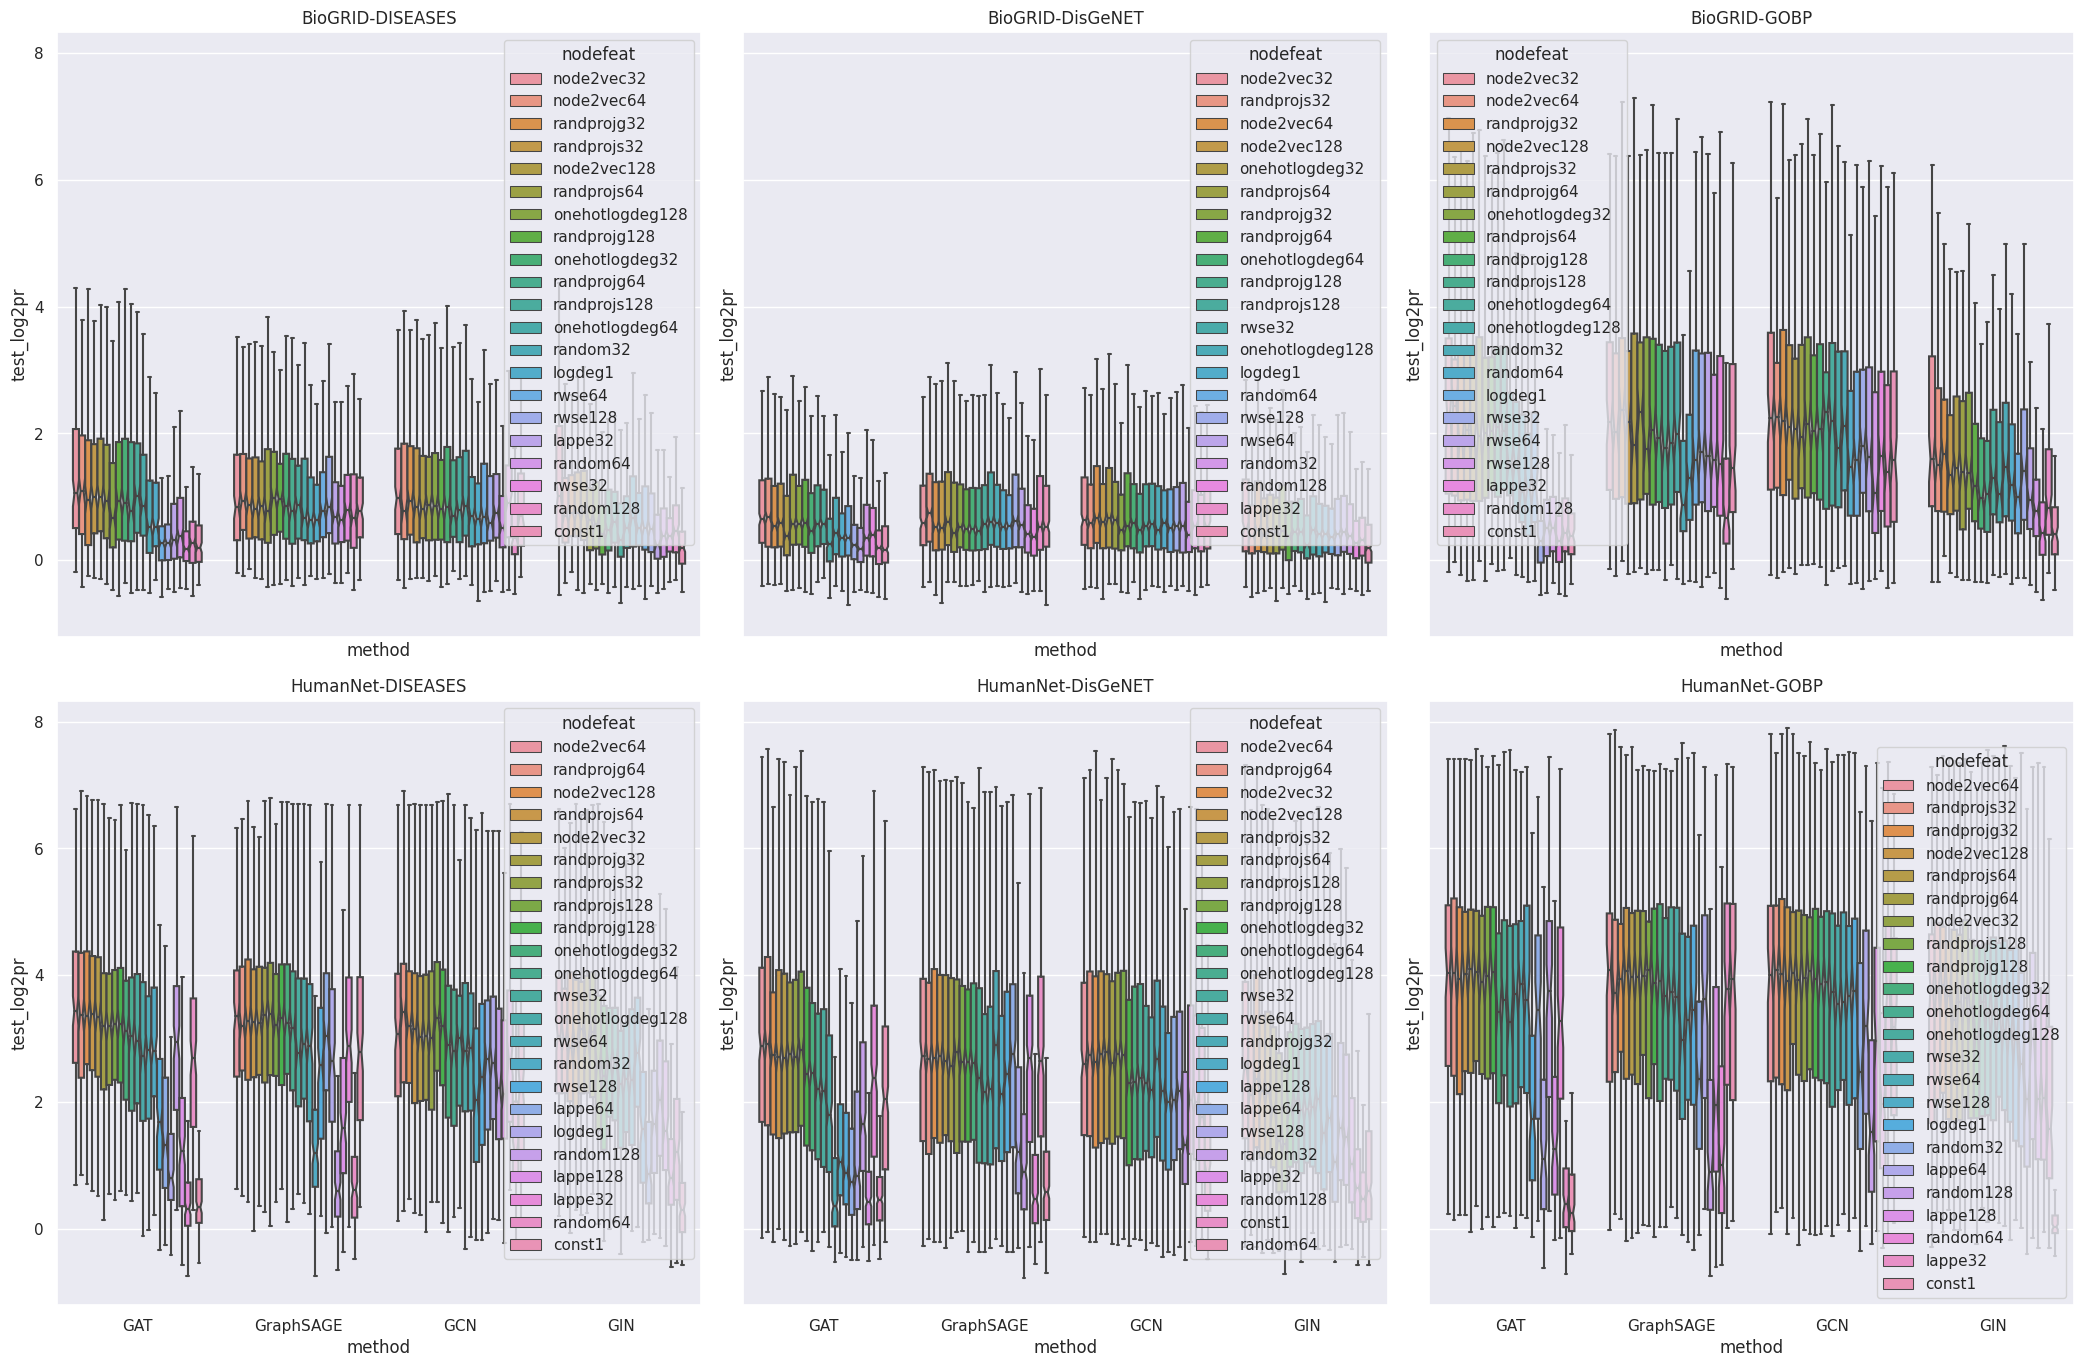

In [5]:
# ----------------------
metric = "test_log2pr"
method_order = ["GAT", "GraphSAGE", "GCN", "GIN"]
# ----------------------

n_networks = len(network_name_mapping)
n_labels = len(label_name_mapping)
n_methods = len(method_name_mapping)

fig, axes = plt.subplots(n_networks, n_labels, figsize=(21, 14), sharey=True, sharex=True)

for ax, (names, group) in zip(axes.ravel(), reduced_df.groupby(["network", "label"])):
    sns.boxplot(
        data=group,
        x="method",
        y=metric,
        hue="nodefeat",
        order=method_order,
        hue_order=(
            group
            .groupby("nodefeat")
            .median(numeric_only=True)
            .sort_values(metric, ascending=False)
            .index.tolist()
        ),
        notch=True,
        showfliers=False,
        ax=ax,
    )
    ax.set_title("-".join(names))

plt.tight_layout()
plt.show()

In [40]:
for (network, label), group in df.groupby(["network", "label"]):
    group
    break

In [41]:
group

,task_name,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc,network,label,method,nodefeat,runid
105,MONDO:0002245,2.995579,-0.300649,-0.484445,0.802237,0.329779,0.261538,BioGRID,DISEASES,GCN,rwse128,1
106,MONDO:0021129,3.753633,-0.067045,0.372971,0.877767,0.448901,0.578634,BioGRID,DISEASES,GCN,rwse128,1
107,MONDO:0000066,6.816137,4.929801,3.090538,0.996017,0.984339,0.733395,BioGRID,DISEASES,GCN,rwse128,1
108,MONDO:0005039,1.280184,0.395852,0.702131,0.702826,0.551501,0.559649,BioGRID,DISEASES,GCN,rwse128,1
109,MONDO:0002320,1.617686,0.055532,-0.146493,0.765985,0.535134,0.464047,BioGRID,DISEASES,GCN,rwse128,1
...,...,...,...,...,...,...,...,...,...,...,...,...
63304,MONDO:0020133,-0.414518,-0.486047,-0.599179,0.324893,0.325449,0.274356,BioGRID,DISEASES,GIN,rwse128,1
63305,MONDO:0015514,0.598110,0.224155,0.124969,0.578901,0.448032,0.489835,BioGRID,DISEASES,GIN,rwse128,1
63306,MONDO:0019042,-0.376850,-0.370536,0.046803,0.394539,0.390718,0.480636,BioGRID,DISEASES,GIN,rwse128,1
63307,MONDO:0024322,-0.199260,0.014312,0.310312,0.455131,0.520938,0.587882,BioGRID,DISEASES,GIN,rwse128,1


In [48]:
(
    group
    .groupby(["network", "label", "method", "nodefeat"], as_index=False)
    .mean(numeric_only=True)
    .sort_values(metric)
    .groupby(["network", "label", "method"], as_index=False)
    .head(1)
)

,network,label,method,nodefeat,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc,runid
31,BioGRID,DISEASES,GIN,node2vec32,0.115125,0.323614,0.286424,0.490273,0.501416,0.494958,1.0
13,BioGRID,DISEASES,GAT,rwse64,0.153847,0.501966,0.314770,0.520056,0.535262,0.505622,1.0
22,BioGRID,DISEASES,GCN,random128,1.455282,0.741249,0.563188,0.677299,0.556504,0.535002,1.0
50,BioGRID,DISEASES,GraphSAGE,random128,2.994062,1.024013,0.920004,0.772560,0.587937,0.554033,1.0


In [23]:
(
    df
    .groupby(["network", "label", "method", "nodefeat"], as_index=False)
    .mean(numeric_only=True)
    .sort_values(metric, ascending=False)
    .drop(columns="runid")
    .groupby(["network", "label", "method"], as_index=False)
    .head(1)
    .sort_values(["network", "label", "method", "nodefeat"])
    .set_index(["network", "label", "method", "nodefeat"])
    .pivot_table(values="test_log2pr", index="method", columns=["network", "label"])
    .style.highlight_max(axis=0)
)

In [7]:
(
    df
    .groupby(["network", "label", "method", "nodefeat"], as_index=False)
    .mean(numeric_only=True)
    .sort_values(metric, ascending=False)
    .groupby(["network", "label", "method"], as_index=False)
    .head(1)
    .sort_values(["network", "label", "method", "nodefeat"])
    .pivot_table(values="test_log2pr", index=["network", "method"], columns=["label"])
    .query("network == 'BioGRID'")
    .style.highlight_max(axis=0)
)

In [11]:
reduced_df = (
    df
    .groupby(["network", "label", "method", "nodefeat"], as_index=False)
    .mean(numeric_only=True)
    .drop(columns="runid")
)
reduced_df

,network,label,method,nodefeat,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc
0,BioGRID,DISEASES,GAT,const1,0.238340,0.483702,0.321610,0.528547,0.518339,0.496639
1,BioGRID,DISEASES,GAT,lappe32,0.375108,0.487512,0.426999,0.576644,0.536577,0.507341
2,BioGRID,DISEASES,GAT,node2vec128,3.401618,1.545038,1.398032,0.869894,0.640542,0.606126
3,BioGRID,DISEASES,GAT,node2vec32,2.860442,1.654077,1.420303,0.820997,0.652183,0.616924
4,BioGRID,DISEASES,GAT,node2vec64,3.068296,1.626807,1.364118,0.842368,0.645657,0.603876
...,...,...,...,...,...,...,...,...,...,...
355,HumanNet,GOBP,GraphSAGE,random32,3.137667,2.737432,2.512110,0.845843,0.757441,0.729611
356,HumanNet,GOBP,GraphSAGE,random64,1.604210,1.654581,1.469912,0.719182,0.684701,0.656453
357,HumanNet,GOBP,GraphSAGE,rwse128,4.776778,3.487360,3.305264,0.943239,0.803227,0.777710
358,HumanNet,GOBP,GraphSAGE,rwse32,5.334309,3.783397,3.588515,0.979777,0.819055,0.792192


In [20]:
reduced_df.query("network == 'HumanNet' & label == 'DISEASES' & method == 'GAT'").sort_values("test_log2pr", ascending=False)

,network,label,method,nodefeat,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc
174,HumanNet,DISEASES,GAT,node2vec64,4.395191,3.462170,3.537044,0.969091,0.808631,0.812168
172,HumanNet,DISEASES,GAT,node2vec128,4.388151,3.527453,3.499121,0.968523,0.810499,0.807442
173,HumanNet,DISEASES,GAT,node2vec32,4.366403,3.413899,3.389740,0.966816,0.803062,0.809694
176,HumanNet,DISEASES,GAT,onehotlogdeg32,3.940623,3.173041,3.107557,0.925571,0.792617,0.781918
182,HumanNet,DISEASES,GAT,rwse32,4.037931,3.211827,3.046212,0.940997,0.794215,0.773373
177,HumanNet,DISEASES,GAT,onehotlogdeg64,3.799274,3.026078,3.016615,0.915190,0.782689,0.775755
179,HumanNet,DISEASES,GAT,random32,3.424418,2.866670,2.937714,0.891824,0.772091,0.775116
178,HumanNet,DISEASES,GAT,random128,3.240470,2.895980,2.921833,0.865962,0.776273,0.779017
175,HumanNet,DISEASES,GAT,onehotlogdeg128,3.589050,3.003585,2.811611,0.898356,0.769498,0.763388
183,HumanNet,DISEASES,GAT,rwse64,3.781932,2.894008,2.795992,0.918914,0.780873,0.768032


In [21]:
reduced_df.query("network == 'HumanNet' & label == 'DISEASES' & method == 'GraphSAGE'").sort_values("test_log2pr", ascending=False)

,network,label,method,nodefeat,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc
222,HumanNet,DISEASES,GraphSAGE,node2vec64,4.752490,3.424072,3.356806,0.992132,0.792665,0.789767
224,HumanNet,DISEASES,GraphSAGE,onehotlogdeg32,4.666341,3.278248,3.349321,0.986901,0.787181,0.782290
220,HumanNet,DISEASES,GraphSAGE,node2vec128,4.737879,3.454493,3.332617,0.991497,0.802068,0.794293
221,HumanNet,DISEASES,GraphSAGE,node2vec32,4.714834,3.395791,3.327067,0.989763,0.788113,0.782006
225,HumanNet,DISEASES,GraphSAGE,onehotlogdeg64,4.657236,3.266126,3.241945,0.986703,0.786740,0.779048
223,HumanNet,DISEASES,GraphSAGE,onehotlogdeg128,4.538751,3.220655,3.128304,0.979942,0.780165,0.773968
218,HumanNet,DISEASES,GraphSAGE,lappe32,4.371461,3.118551,2.995533,0.966741,0.775972,0.783266
230,HumanNet,DISEASES,GraphSAGE,rwse32,4.398449,3.084546,2.949464,0.969393,0.781570,0.768210
219,HumanNet,DISEASES,GraphSAGE,lappe64,4.496300,3.127451,2.933822,0.976084,0.779748,0.778579
216,HumanNet,DISEASES,GraphSAGE,const1,4.222113,2.957353,2.867254,0.953469,0.774277,0.753564


In [3]:
method_order = (
    df
    .groupby("method")
    .mean(numeric_only=True)
    .sort_values("test_log2pr", ascending=False)
    .index.tolist()
)
print(f"Overall method rank:\n{pformat(method_order)}")

Overall method rank:
['labelprop',
 'adj-logreg',
 'adj-svm',
 'n2v-logreg',
 'n2v-svm',
 'graphsage',
 'lapeig-logreg',
 'gcn',
 'gat',
 'walklets-logreg',
 'line2-logreg',
 'gin',
 'line1-logreg',
 'randne-logreg',
 'svd-logreg',
 'hope-logreg',
 'louvainne-logreg']


In [59]:
!ls

aggregated_results  archive   genes.txt  submit_all.sh
analysis.ipynb	    datasets  logs	 tmp.png


In [78]:
df

,task_name,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc,network,label,method,runid
0,MONDO:0021034,5.452130,2.213430,4.299555,0.907676,0.704289,0.771057,humannet,disgenet,svd-logreg,4.0
1,MONDO:0002243,3.999161,1.508517,1.391891,0.916140,0.666234,0.685053,humannet,disgenet,svd-logreg,4.0
2,MONDO:0002245,2.753485,1.547721,1.049140,0.828769,0.646123,0.604265,humannet,disgenet,svd-logreg,4.0
3,MONDO:0001703,5.943613,4.183546,3.712374,0.966340,0.785444,0.927036,humannet,disgenet,svd-logreg,4.0
4,MONDO:0013099,6.842475,3.703523,2.558013,0.994086,0.841139,0.797267,humannet,disgenet,svd-logreg,4.0
...,...,...,...,...,...,...,...,...,...,...,...
181023,MONDO:0056803,6.664968,2.663961,5.868247,0.991963,0.674960,0.927969,string,disgenet,n2v-svm,2.0
181024,MONDO:0100284,5.433985,3.508231,5.873212,0.966521,0.792660,0.926787,string,disgenet,n2v-svm,2.0
181025,MONDO:0020019,4.799468,2.360761,1.481513,0.947510,0.714223,0.712036,string,disgenet,n2v-svm,2.0
181026,MONDO:0021002,4.301301,2.680361,3.039071,0.933164,0.820492,0.802115,string,disgenet,n2v-svm,2.0


In [101]:
for i, j in zip(
    tmp_df.droplevel(0)["test_log2pr"].values,
    tmp2_df.droplevel(0)["test_log2pr"].values,
):
    print(f"{i:.4f} ± {j:.4f}")

3.7705 ± 0.0000
3.7474 ± 0.0000
2.9066 ± 0.0837
2.9335 ± 0.0265
2.9282 ± 0.0970
3.1663 ± 0.0627
1.9678 ± 0.0000
3.6518 ± 0.0000
2.6426 ± 0.0000
2.3008 ± 0.0000
2.4164 ± 0.0000
2.0130 ± 0.0207
3.4302 ± 0.0410
3.2176 ± 0.0486
2.7583 ± 0.0060
2.0435 ± 0.0000
2.6379 ± 0.0478
3.0248 ± 0.0000
2.8986 ± 0.0000
2.2848 ± 0.1109
2.5772 ± 0.0440
2.5081 ± 0.0113
2.7226 ± 0.0764
1.7247 ± 0.0000
3.1203 ± 0.0000
2.2829 ± 0.0000
2.0566 ± 0.0000
2.1402 ± 0.0000
1.7539 ± 0.0279
2.7688 ± 0.0382
2.6351 ± 0.0444
2.2733 ± 0.0312
1.8827 ± 0.0000
1.9995 ± 0.0297
3.8565 ± 0.0000
3.6947 ± 0.0000
3.4493 ± 0.0865
3.6448 ± 0.0402
3.5786 ± 0.0530
3.6471 ± 0.0510
2.6067 ± 0.0000
3.8063 ± 0.0000
3.6716 ± 0.0000
3.4978 ± 0.0000
3.6056 ± 0.0000
3.1444 ± 0.0212
3.9272 ± 0.0139
3.5094 ± 0.0894
3.6937 ± 0.0262
2.4556 ± 0.0000
3.1705 ± 0.0267


In [98]:
tmp_df = (
    df
    .query("network == 'humannet'")
    .drop(columns=["network"])
    .groupby(["label", "method"])
    .mean(numeric_only=True)[["test_log2pr"]]
)
tmp2_df = (
    df
    .query("network == 'humannet'")
    .drop(columns=["network"])
    .groupby(["label", "method", "runid"])
    .mean(numeric_only=True)
    .groupby(["label", "method"])
    .std()[["test_log2pr"]]
)
tmp_df

test_log2pr
label    method                       
diseases adj-logreg           3.770503
         adj-svm              3.747426
         gat                  2.906589
         gcn                  2.933541
         gin                  2.928151
         graphsage            3.166320
         hope-logreg          1.967820
         labelprop            3.651757
         lapeig-logreg        2.642624
         line1-logreg         2.300782
         line2-logreg         2.416421
         louvainne-logreg     2.013031
         n2v-logreg           3.430156
         n2v-svm              3.217580
         randne-logreg        2.758303
         svd-logreg           2.043525
         walklets-logreg      2.637867
disgenet adj-logreg           3.024752
         adj-svm              2.898560
         gat                  2.284759
         gcn                  2.577179
         gin                  2.508099
         graphsage            2.722551
         hope-logreg          1.724720
         labelprop            3.120283
         lapeig-logreg        2.282933
         line1-logreg         2.056555
         line2-logreg         2.140236
         louvainne-logreg     1.753902
         n2v-logreg           2.768819
         n2v-svm              2.635099
         randne-logreg        2.273314
         svd-logreg           1.882704
         walklets-logreg      1.999457
gobp     adj-logreg           3.856508
         adj-svm              3.694687
         gat                  3.449335
         gcn                  3.644815
         gin                  3.578603
         graphsage            3.647083
         hope-logreg          2.606683
         labelprop            3.806279
         lapeig-logreg        3.671635
         line1-logreg         3.497806
         line2-logreg         3.605620
         louvainne-logreg     3.144401
         n2v-logreg           3.927152
         n2v-svm              3.509400
         randne-logreg        3.693742
         svd-logreg           2.455613
         walklets-logreg      3.170516

In [135]:
tmp_df.melt(ignore_index=False)

variable     value
task_name     method                                  
MONDO:0000066 ADJ-LogReg        train_log2pr  7.372243
              ADJ-SVM           train_log2pr  7.372243
              GAT               train_log2pr  6.738709
              GCN               train_log2pr  6.935654
              GIN               train_log2pr  7.130926
...                                      ...       ...
MONDO:0700092 N2V-LogReg         test_log2pr  3.184952
              N2v-SVM            test_log2pr  3.382227
              RandomNE-LogReg    test_log2pr  2.146413
              SVD-LogReg         test_log2pr  1.671917
              Walkdlets-LogReg   test_log2pr  2.541659

[15198 rows x 2 columns]

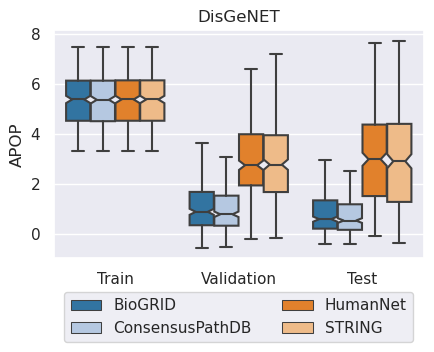

In [269]:
# ---------------------
selected_method = "ADJ-LogReg"
selected_label = "DisGeNET"
selected_metric = "log2pr"
# ---------------------

tmp_df = (
    df
    .query("method == @selected_method & label == @selected_label")
    .groupby(["task_name", "network", "method"])
    .mean(numeric_only=True)[[
        f"train_{selected_metric}",
        f"val_{selected_metric}",
        f"test_{selected_metric}",
    ]]
    .rename(columns={
        f"train_{selected_metric}": "Train",
        f"val_{selected_metric}": "Validation",
        f"test_{selected_metric}": "Test",
    })
    .melt(ignore_index=False)
    .reset_index()
)
# print(tmp_df)

plt.figure(figsize=(4.5, 4))
sns.boxplot(
    tmp_df,
    hue="network",
    y="value",
    x="variable",
    notch=True,
    showfliers=False,
    palette="tab20",
)
plt.xlabel("")
plt.ylabel("APOP")
plt.title(selected_label)
plt.legend(loc="lower center", ncols=2, bbox_to_anchor=(0.5, -0.4))
plt.tight_layout()
# plt.savefig("tmp.png", dpi=300, bbox_inches="tight")
plt.show()

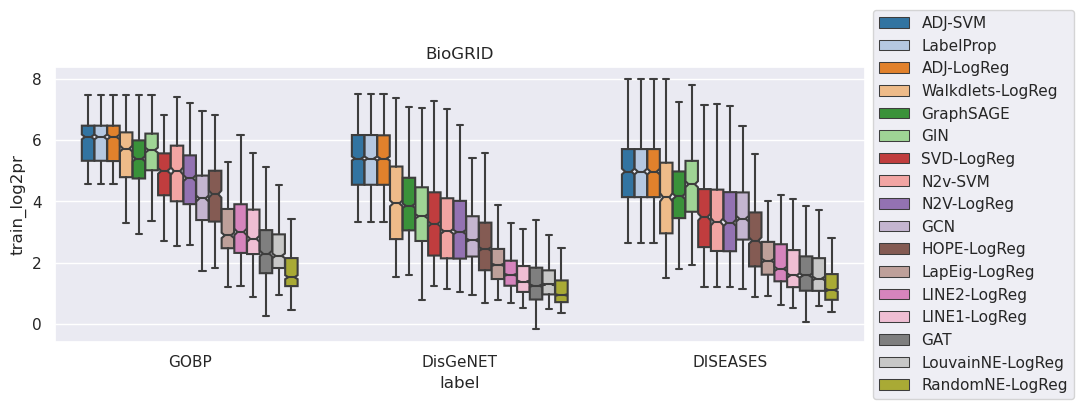

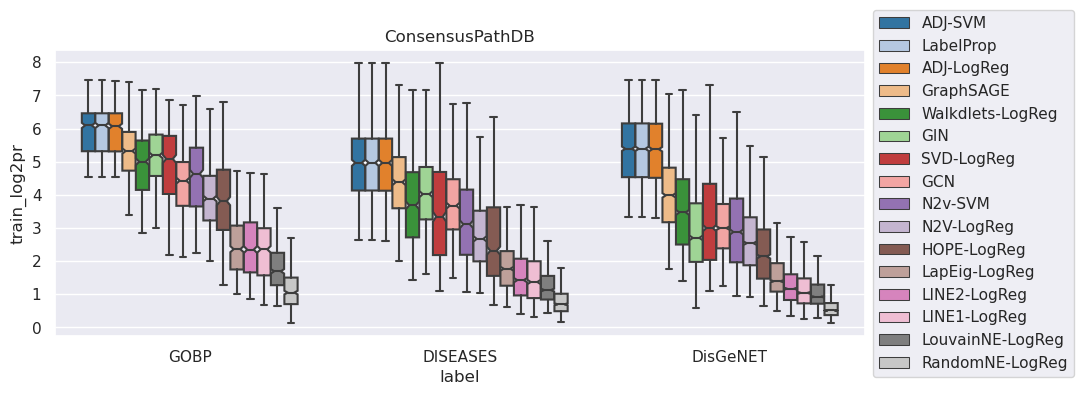

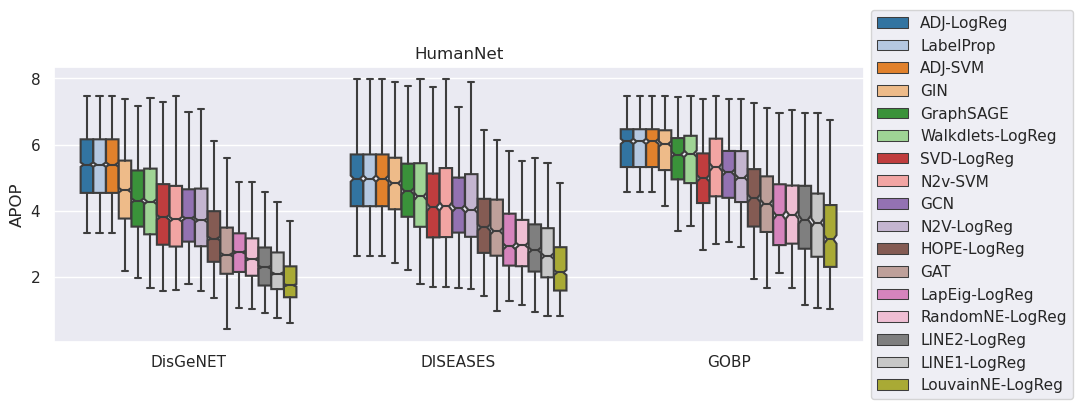

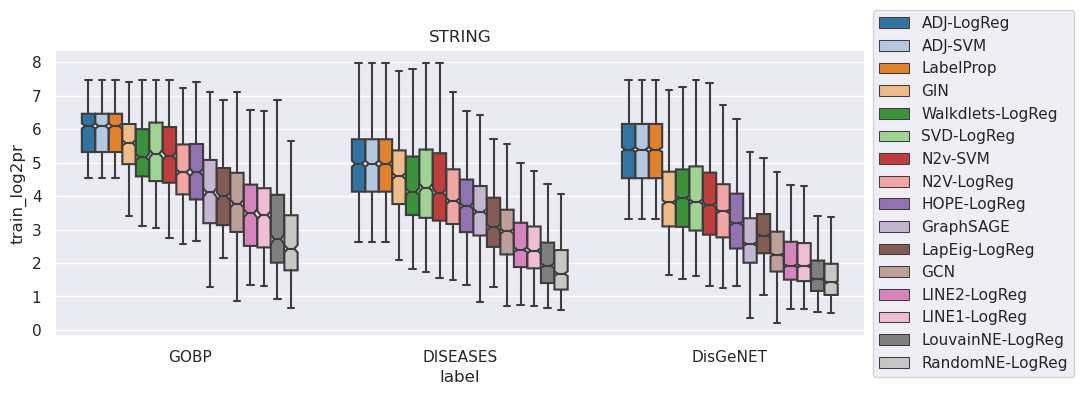

In [228]:
# ---------------
metric = "train_log2pr"
# ---------------

for network, group in df.groupby("network"):
    plt.figure(figsize=(11, 4))
    sns.boxplot(
        data=group,
        y=metric,
        hue="method",
        x="label",
        hue_order=(
            group
            .groupby("method")
            .median(numeric_only=True)
            .sort_values(metric, ascending=False)
            .index.tolist()
        ),
        notch=True,
        showfliers=False,
        palette="tab20",
    )
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(network)
    plt.tight_layout()
#     if network == "HumanNet":
#         plt.xlabel("")
#         plt.ylabel("APOP")
#         plt.savefig("tmp.png", dpi=300, bbox_inches="tight")
    plt.show()
#     break

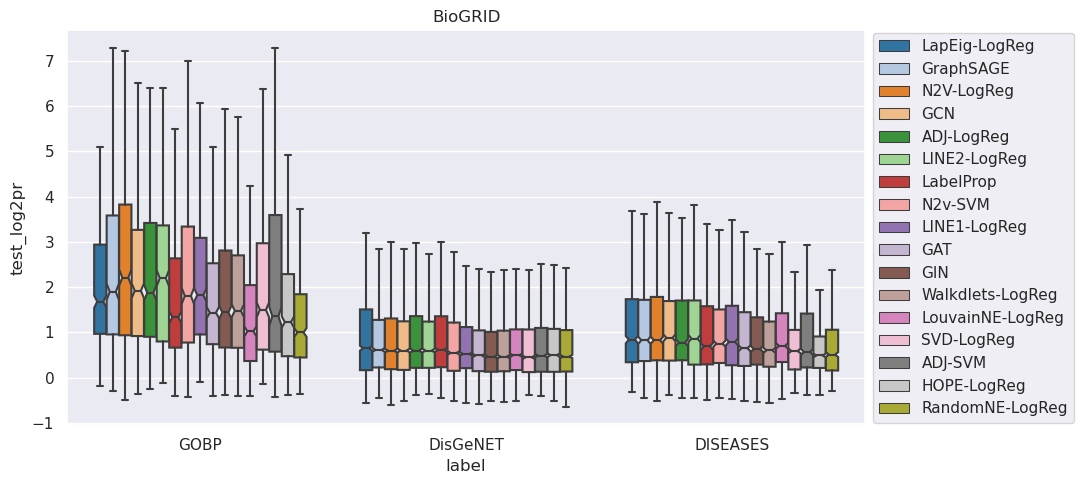

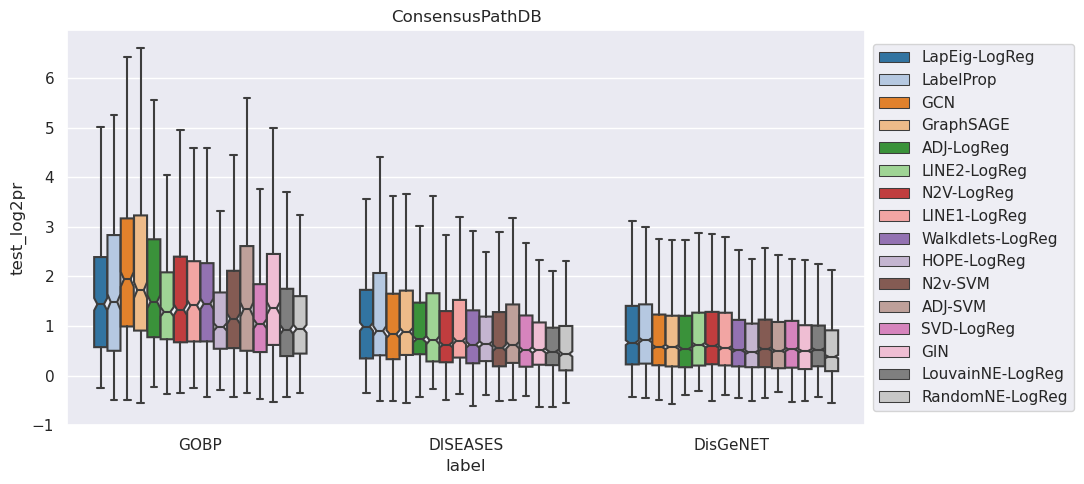

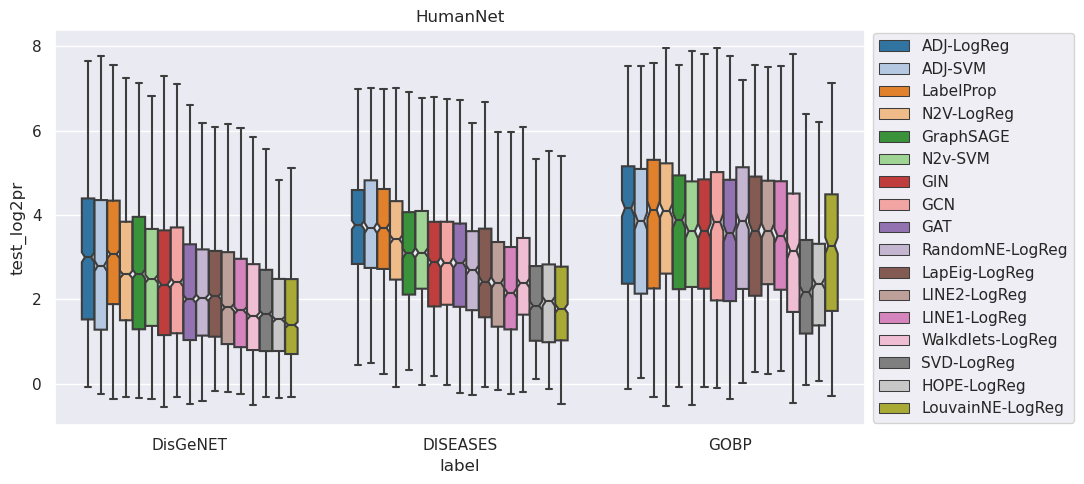

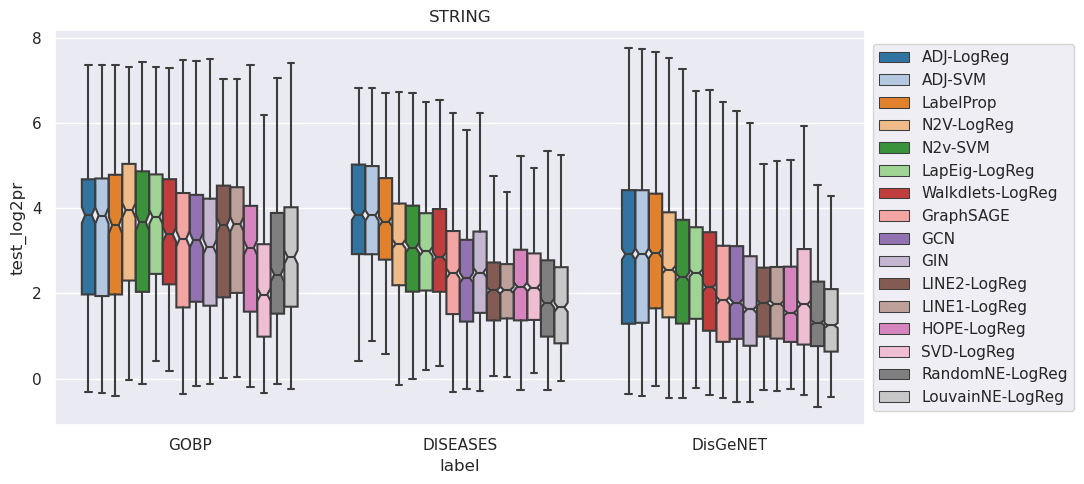

In [113]:
# ---------------
metric = "test_log2pr"
# ---------------

for network, group in df.groupby("network"):
    plt.figure(figsize=(11, 5))
    sns.boxplot(
        data=group,
        y=metric,
        hue="method",
        x="label",
        hue_order=(
            group
            .groupby("method")
            .median(numeric_only=True)
            .sort_values(metric, ascending=False)
            .index.tolist()
        ),
        notch=True,
        showfliers=False,
        palette="tab20",
    )
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(network)
    plt.tight_layout()
#     if network == "HumanNet":
#         plt.savefig("tmp.png", dpi=300, bbox_inches="tight")
    plt.show()
#     break

In [5]:
df

,task_name,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc,network,label,method,runid
0,MONDO:0021034,5.452130,2.213430,4.299555,0.907676,0.704289,0.771057,humannet,disgenet,svd-logreg,4.0
1,MONDO:0002243,3.999161,1.508517,1.391891,0.916140,0.666234,0.685053,humannet,disgenet,svd-logreg,4.0
2,MONDO:0002245,2.753485,1.547721,1.049140,0.828769,0.646123,0.604265,humannet,disgenet,svd-logreg,4.0
3,MONDO:0001703,5.943613,4.183546,3.712374,0.966340,0.785444,0.927036,humannet,disgenet,svd-logreg,4.0
4,MONDO:0013099,6.842475,3.703523,2.558013,0.994086,0.841139,0.797267,humannet,disgenet,svd-logreg,4.0
...,...,...,...,...,...,...,...,...,...,...,...
181023,MONDO:0056803,6.664968,2.663961,5.868247,0.991963,0.674960,0.927969,string,disgenet,n2v-svm,2.0
181024,MONDO:0100284,5.433985,3.508231,5.873212,0.966521,0.792660,0.926787,string,disgenet,n2v-svm,2.0
181025,MONDO:0020019,4.799468,2.360761,1.481513,0.947510,0.714223,0.712036,string,disgenet,n2v-svm,2.0
181026,MONDO:0021002,4.301301,2.680361,3.039071,0.933164,0.820492,0.802115,string,disgenet,n2v-svm,2.0


In [26]:
reduced_df.groupby(["task_name", "network"]).rank(pct=True, method="max")

,label,method,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc
0,0.5,0.058824,0.823529,0.735294,0.470588,1.000000,0.941176,0.970588
1,0.5,0.117647,0.823529,0.676471,0.352941,1.000000,0.264706,0.411765
2,0.5,0.176471,0.147059,0.117647,0.029412,0.176471,0.294118,0.294118
3,0.5,0.235294,0.441176,0.500000,0.441176,0.588235,0.911765,0.705882
4,0.5,0.294118,0.676471,0.235294,0.088235,0.764706,0.176471,0.117647
...,...,...,...,...,...,...,...,...
35767,1.0,0.750000,0.500000,0.937500,0.687500,0.562500,0.937500,0.937500
35768,1.0,0.812500,0.687500,0.562500,0.312500,0.687500,0.625000,0.562500
35769,1.0,0.875000,0.062500,0.125000,0.125000,0.062500,0.312500,0.187500
35770,1.0,0.937500,1.000000,0.062500,0.062500,1.000000,0.062500,0.125000


In [115]:
reduced_df = (
    df
    .groupby(["network", "label", "task_name", "method"], as_index=False)
    .median()
    .drop(columns=["runid"])
)

# Rank method for each combination of task & network
reduced_df["network_rank"] = reduced_df.groupby(["task_name", "method"]).rank(pct=True, method="max")["test_log2pr"]

# Rank network for each combination of task & method
reduced_df["method_rank"] = reduced_df.groupby(["task_name", "network"]).rank(pct=True, method="max")["test_log2pr"]

reduced_df

,network,label,task_name,method,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc,network_rank,method_rank
0,BioGRID,DISEASES,MONDO:0000066,ADJ-LogReg,7.179385,5.184439,4.852310,1.000000,0.993311,0.945062,0.375,0.470588
1,BioGRID,DISEASES,MONDO:0000066,ADJ-SVM,7.179385,5.161099,4.683363,1.000000,0.943409,0.860000,0.250,0.352941
2,BioGRID,DISEASES,MONDO:0000066,GAT,6.046536,4.437915,3.649281,0.960300,0.947975,0.833642,0.250,0.029412
3,BioGRID,DISEASES,MONDO:0000066,GCN,7.004356,5.086224,4.847134,0.998845,0.992939,0.910679,0.250,0.441176
4,BioGRID,DISEASES,MONDO:0000066,GIN,7.163479,4.865460,4.152402,0.999904,0.939109,0.789444,0.250,0.088235
...,...,...,...,...,...,...,...,...,...,...,...,...
35767,STRING,GOBP,GO:0150104,N2V-LogReg,5.739169,5.375338,4.875056,0.992453,0.980823,0.983963,0.750,0.687500
35768,STRING,GOBP,GO:0150104,N2v-SVM,6.037356,5.070493,4.636713,0.998076,0.954205,0.952373,0.750,0.312500
35769,STRING,GOBP,GO:0150104,RandomNE-LogReg,3.000811,3.803565,3.176077,0.903333,0.897641,0.880450,0.750,0.125000
35770,STRING,GOBP,GO:0150104,SVD-LogReg,6.125413,3.240197,2.819784,1.000000,0.875197,0.880336,0.750,0.062500


In [246]:
for i in sorted(df.method.unique()):
    print(f'"{i}",')

"ADJ-LogReg",
"ADJ-SVM",
"GAT",
"GCN",
"GIN",
"GraphSAGE",
"HOPE-LogReg",
"LINE1-LogReg",
"LINE2-LogReg",
"LabelProp",
"LapEig-LogReg",
"LouvainNE-LogReg",
"N2V-LogReg",
"N2v-SVM",
"RandomNE-LogReg",
"SVD-LogReg",
"Walkdlets-LogReg",


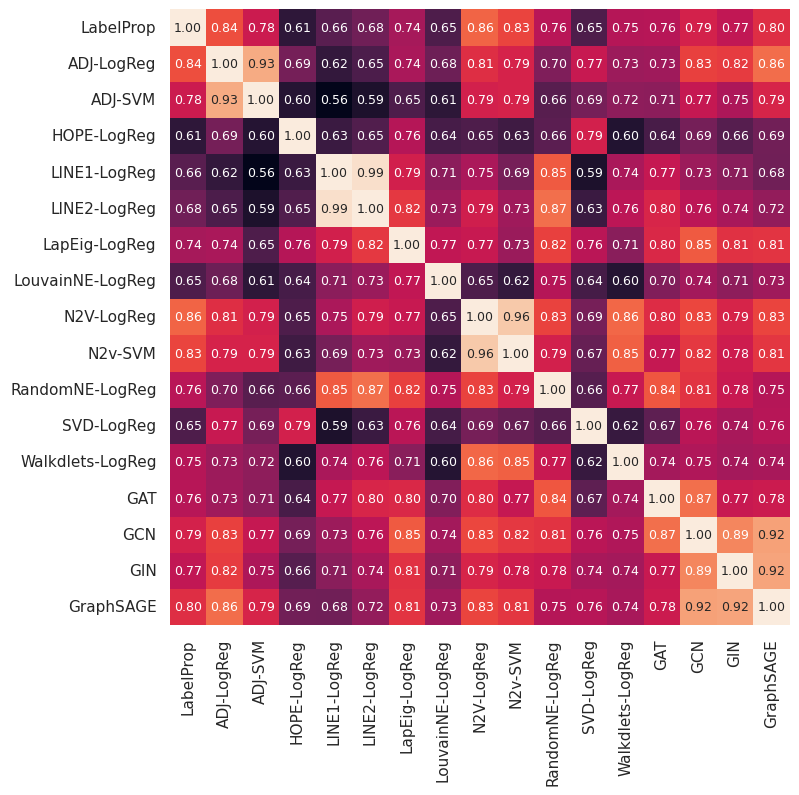

In [278]:
methods = [
    "LabelProp",
    "ADJ-LogReg",
    "ADJ-SVM",
    "HOPE-LogReg",
    "LINE1-LogReg",
    "LINE2-LogReg",
    "LapEig-LogReg",
    "LouvainNE-LogReg",
    "N2V-LogReg",
    "N2v-SVM",
    "RandomNE-LogReg",
    "SVD-LogReg",
    "Walkdlets-LogReg",
    "GAT",
    "GCN",
    "GIN",
    "GraphSAGE",
]

plt.figure(figsize=(8, 8))
sns.heatmap(
    data=(
        df
        .query("network == 'HumanNet'")
        .pivot_table("test_log2pr", "task_name", "method")[methods]
        .corr("spearman")
    ),
    cbar=False,
    annot=True,
    fmt=".2f",
    annot_kws={'size': 9},
)
plt.xlabel("")
plt.ylabel("")
# plt.tight_layout()
plt.savefig("tmp.png", dpi=300, bbox_inches="tight")
plt.show()

In [239]:
help(df.pivot_table)

Help on method pivot_table in module pandas.core.frame:

pivot_table(values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False, sort=True) -> 'DataFrame' method of pandas.core.frame.DataFrame instance
    Create a spreadsheet-style pivot table as a DataFrame.
    
    The levels in the pivot table will be stored in MultiIndex objects
    (hierarchical indexes) on the index and columns of the result DataFrame.
    
    Parameters
    ----------
    values : column to aggregate, optional
    index : column, Grouper, array, or list of the previous
        If an array is passed, it must be the same length as the data. The
        list can contain any of the other types (except list).
        Keys to group by on the pivot table index.  If an array is passed,
        it is being used as the same manner as column values.
    columns : column, Grouper, array, or list of the previous
        If an array is passed, it m

In [237]:
help(df.corr)

Help on method corr in module pandas.core.frame:

corr(method: 'str | Callable[[np.ndarray, np.ndarray], float]' = 'pearson', min_periods: 'int' = 1, numeric_only: 'bool | lib.NoDefault' = <no_default>) -> 'DataFrame' method of pandas.core.frame.DataFrame instance
    Compute pairwise correlation of columns, excluding NA/null values.
    
    Parameters
    ----------
    method : {'pearson', 'kendall', 'spearman'} or callable
        Method of correlation:
    
        * pearson : standard correlation coefficient
        * kendall : Kendall Tau correlation coefficient
        * spearman : Spearman rank correlation
        * callable: callable with input two 1d ndarrays
            and returning a float. Note that the returned matrix from corr
            will have 1 along the diagonals and will be symmetric
            regardless of the callable's behavior.
    min_periods : int, optional
        Minimum number of observations required per pair of columns
        to have a valid resul

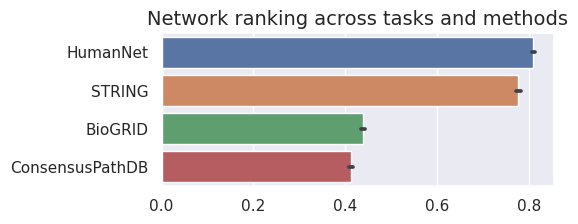

In [235]:
plt.figure(figsize=(5.8, 2.4))
sns.barplot(
    reduced_df,
    y="network",
    x="network_rank",
    order=(
        reduced_df
        .groupby("network")
        .mean(numeric_only=True)["network_rank"]
        .sort_values(ascending=False)
        .index.tolist()
    ),
)

plt.ylabel("")
plt.xlabel("")
plt.title("Network ranking across tasks and methods", fontsize=14)

plt.tight_layout()
plt.savefig("tmp.png", dpi=300, bbox_inches="tight")
plt.show()

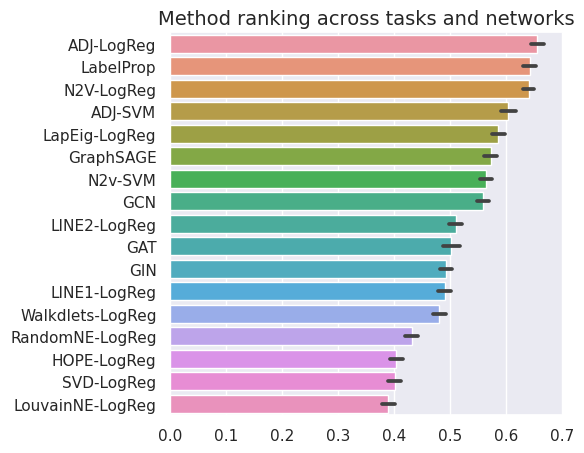

In [234]:
plt.figure(figsize=(6, 4.7))
sns.barplot(
    reduced_df,
    y="method",
    x="method_rank",
    order=(
        reduced_df
        .groupby("method")
        .mean(numeric_only=True)["method_rank"]
        .sort_values(ascending=False)
        .index.tolist()
    ),
)

plt.ylabel("")
plt.xlabel("")
plt.title("Method ranking across tasks and networks", fontsize=14)

plt.tight_layout()
# plt.savefig("tmp.png", dpi=300, bbox_inches="tight")
plt.show()

In [2]:
df = pd.read_csv("aggregated_results/main_results_2023-03-12.csv")
df

,task_name,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc,network,label,method,runid
0,MONDO:0021034,5.452130,2.213430,4.299555,0.907676,0.704289,0.771057,humannet,disgenet,svd-logreg,4.0
1,MONDO:0002243,3.999161,1.508517,1.391891,0.916140,0.666234,0.685053,humannet,disgenet,svd-logreg,4.0
2,MONDO:0002245,2.753485,1.547721,1.049140,0.828769,0.646123,0.604265,humannet,disgenet,svd-logreg,4.0
3,MONDO:0001703,5.943613,4.183546,3.712374,0.966340,0.785444,0.927036,humannet,disgenet,svd-logreg,4.0
4,MONDO:0013099,6.842475,3.703523,2.558013,0.994086,0.841139,0.797267,humannet,disgenet,svd-logreg,4.0
...,...,...,...,...,...,...,...,...,...,...,...
97555,MONDO:0020133,7.967881,2.171143,3.855464,1.000000,0.756337,0.919821,string,diseases,walklets-logreg,4.0
97556,MONDO:0015514,4.878314,2.888149,3.178688,0.963064,0.719374,0.786264,string,diseases,walklets-logreg,4.0
97557,MONDO:0019042,2.704583,0.801325,1.233941,0.897980,0.641399,0.680139,string,diseases,walklets-logreg,4.0
97558,MONDO:0024322,5.498722,3.921747,3.676707,0.981815,0.955727,0.931447,string,diseases,walklets-logreg,4.0


In [3]:
method_order = (
    df
    .groupby("method")
    .mean(numeric_only=True)
    .sort_values("test_log2pr", ascending=False)
    .index.tolist()
)
print(f"Overall method rank:\n{pformat(method_order)}")

Overall method rank:
['n2v-logreg',
 'lapeig-logreg',
 'walklets-logreg',
 'line2-logreg',
 'line1-logreg',
 'randne-logreg',
 'svd-logreg',
 'hope-logreg',
 'louvainne-logreg']


In [ ]:
# ---------------
metric = "test_log2pr"
# ---------------

for network, group in df.groupby("network"):
    plt.figure(figsize=(10, 5))
    sns.boxplot(
        data=group,
        y=metric,
        hue="method",
        x="label",
        hue_order=(
            group
            .groupby("method")
            .median(numeric_only=True)
            .sort_values(metric, ascending=False)
            .index.tolist()
        ),
        notch=True,
        showfliers=False,
    )
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(network)
    plt.tight_layout()
    plt.show()
#     break